In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")
threshold = 30

# Create a new dataframe that only includes data that meets the threshold criteria
df = df.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= threshold )

# Ethnicity 

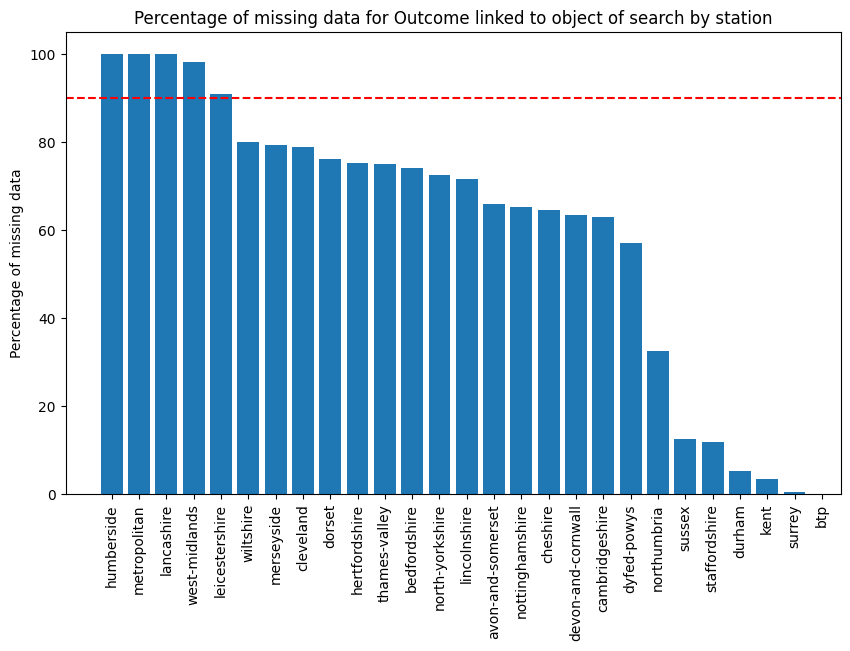

In [2]:
# Calculate the percentage of missing data for each station
missing_perc = df[df['Outcome linked to object of search'].isna()].groupby('station').size() / df.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Outcome linked to object of search by station')

# Add a horizontal line at 95%
plt.axhline(y=90, color='r', linestyle='--')

plt.show()


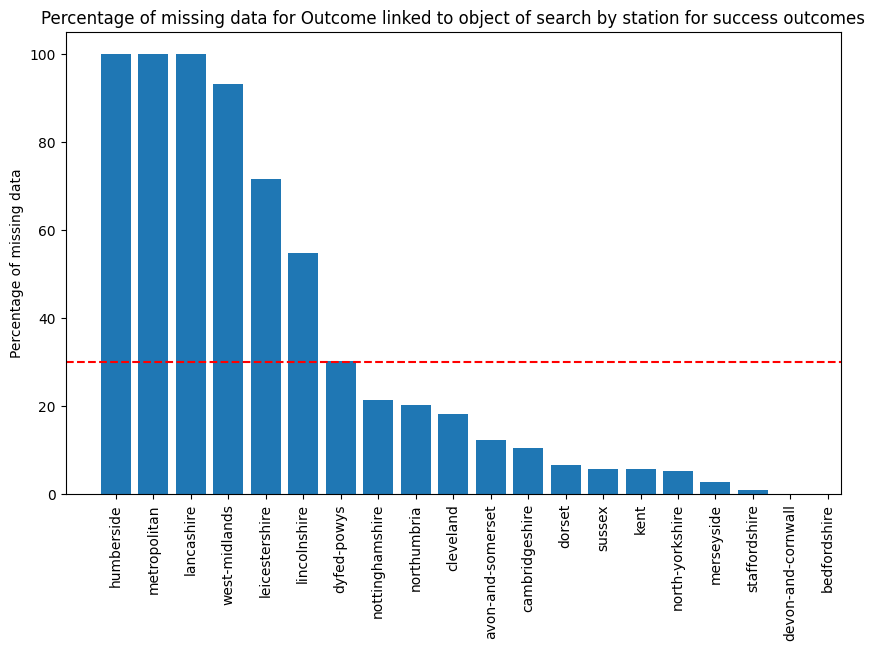

In [3]:
success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']

# Filter the dataframe to include only the success outcomes specified
df_success_outcomes = df[df['Outcome'].isin(success_outcomes)]

# Group the dataframe by station and calculate the percentage of missing values for each station
missing_perc = df_success_outcomes[df_success_outcomes['Outcome linked to object of search'].isna()].groupby('station').size() / df_success_outcomes.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.axhline(y=30, color='r', linestyle='--')

plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Outcome linked to object of search by station for success outcomes')
plt.show()


In [4]:
df_et = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)
df_et.loc[ df_et['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False


In [5]:
def clean (df):
    
    df_ = df.copy()
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']
    
    df_['Outcome linked to object of search'] = df_['Outcome linked to object of search'].fillna(False)
    df_['Removal of more than just outer clothing'] = df_['Removal of more than just outer clothing'].fillna(False)
    
    df_ = df_[df_['Age range'] != 'under 10']

    # Remove rows where gender is 'Other'
    df_ = df_[df_['Gender'] != 'Other']
    
    df_.loc[df_['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False


    df_['success'] = df_.apply(lambda x: 1 if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else 0, axis=1)
    
    return df_

df_et = clean(df_et)


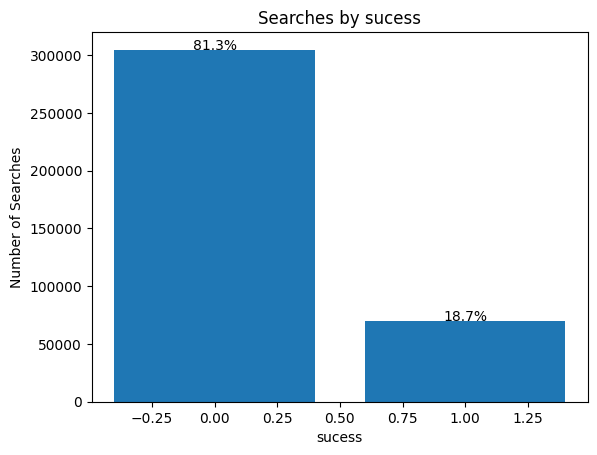

In [6]:
# count the number of searches for each gender
counts = df_et['success'].value_counts()

# create a bar plot
plt.bar(counts.index, counts.values)

# set the x-axis and y-axis labels
plt.xlabel('sucess')
plt.ylabel('Number of Searches')

# set the title of the plot
plt.title('Searches by sucess')

# add percentages to each bar
total = sum(counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v/total*100:.1f}%", ha='center')

# show the plot
plt.show()


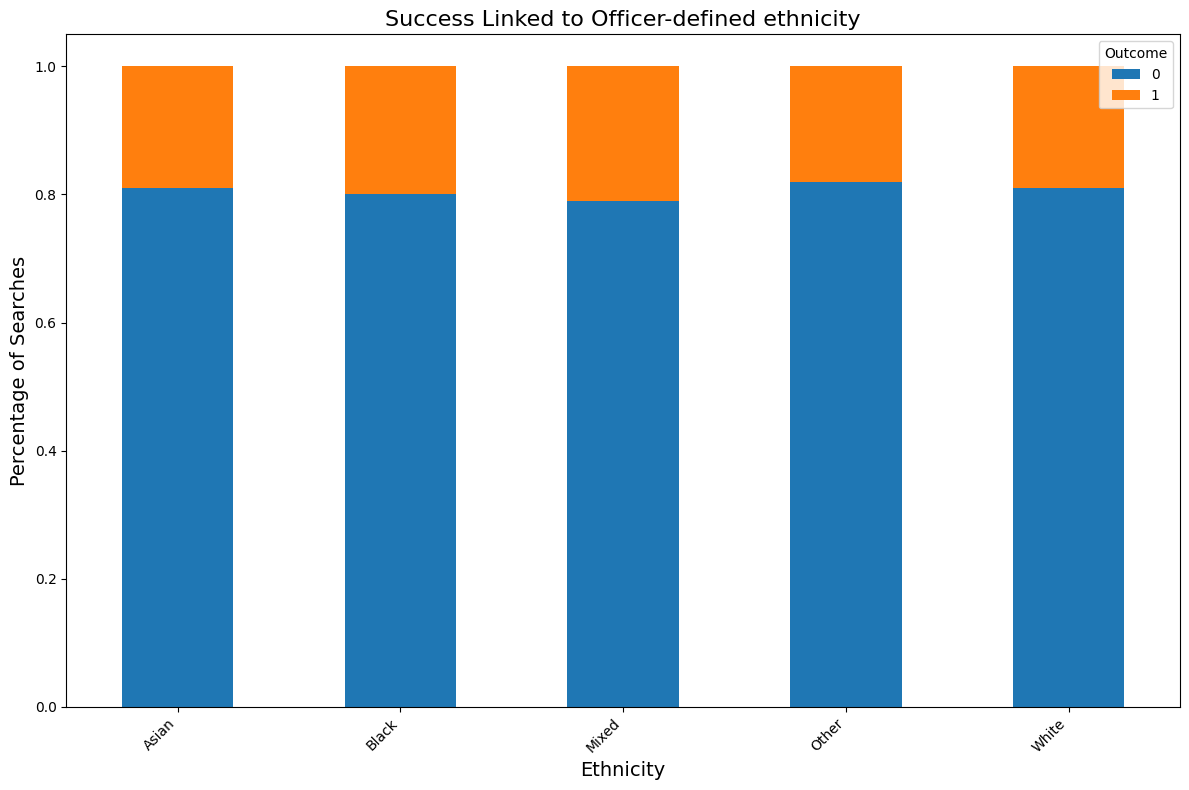

In [7]:
data = df_et.copy()

# Subset the dataframe to only include the columns of interest
ethnicity_outcome_df = data[['Officer-defined ethnicity', 'success']]

# Group the dataframe by ethnicity and outcome and calculate the count
ethnicity_outcome_count = ethnicity_outcome_df.groupby(['Officer-defined ethnicity', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity as rows, outcome as columns, and count as values
ethnicity_outcome_pivot = ethnicity_outcome_count.pivot(index='Officer-defined ethnicity', columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity
ethnicity_outcome_pct = ethnicity_outcome_pivot.div(ethnicity_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Success Linked to Officer-defined ethnicity', fontsize=16)
ax.set_xlabel('Ethnicity', fontsize=14)
ax.set_ylabel('Percentage of Searches', fontsize=14)
ax.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


In [8]:
def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    return max_val - min_val > 0.05

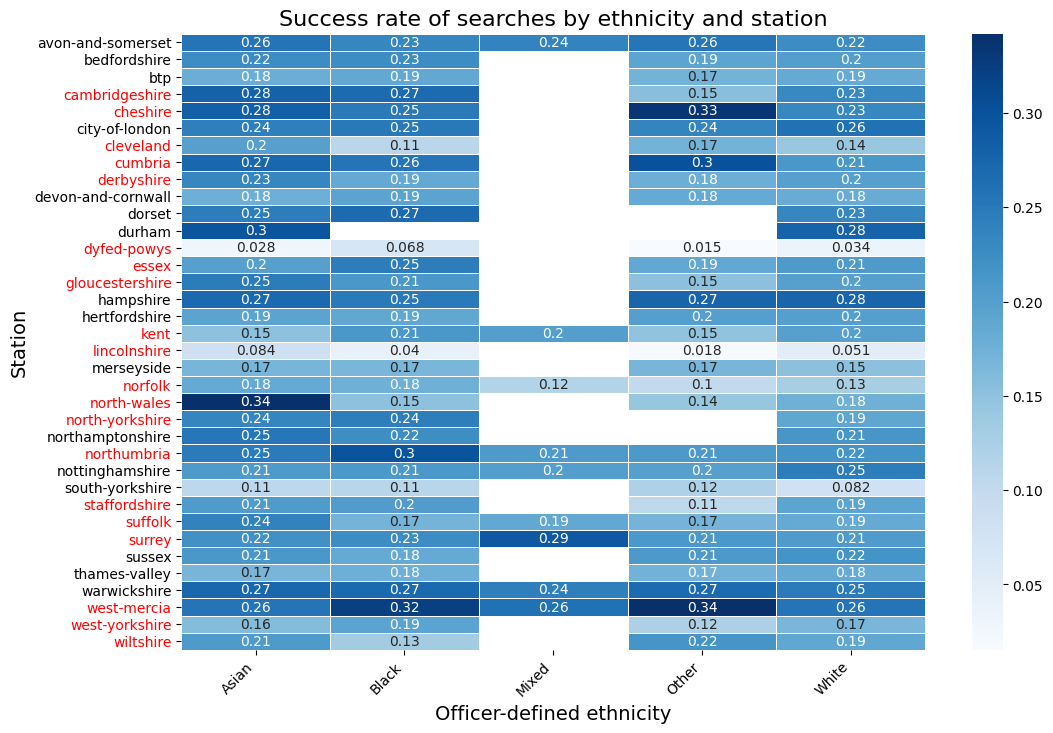

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select relevant columns


def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    return max_val - min_val > 0.05

data = df_et[['station', 'Officer-defined ethnicity', 'success',"Gender"]].copy()



data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns='Officer-defined ethnicity', 
                              values='success', aggfunc='mean')


data_test=  pivot_data.copy()
# Convert categorical column to string column

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations  = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)



# Set plot title and axis labels
ax.set_title('Success rate of searches by ethnicity and station', fontsize=16)
ax.set_xlabel('Officer-defined ethnicity', fontsize=14)

ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')


plt.show()

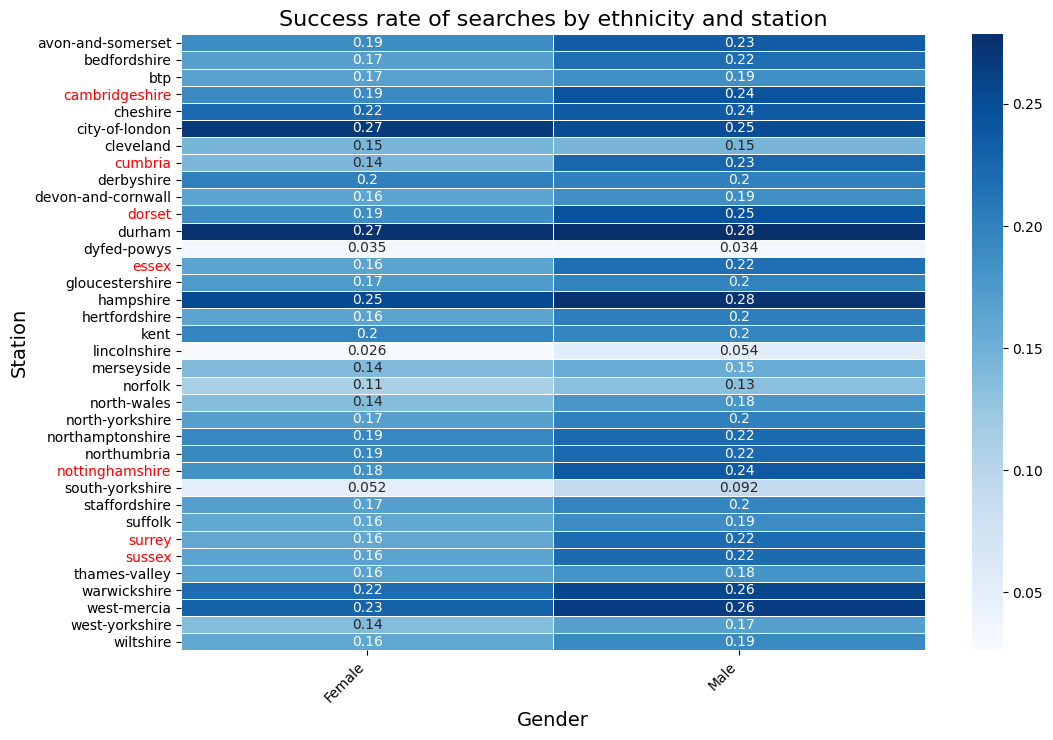

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select relevant columns
data = df_et[['station', 'success',"Gender"]].copy()



data['Gender'] = data['Gender'].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns='Gender', 
                              values='success', aggfunc='mean')


data_test=  pivot_data.copy()
# Convert categorical column to string column

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations  = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)



# Set plot title and axis labels
ax.set_title('Success rate of searches by ethnicity and station', fontsize=16)
ax.set_xlabel('Gender', fontsize=14)

ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')


plt.show()

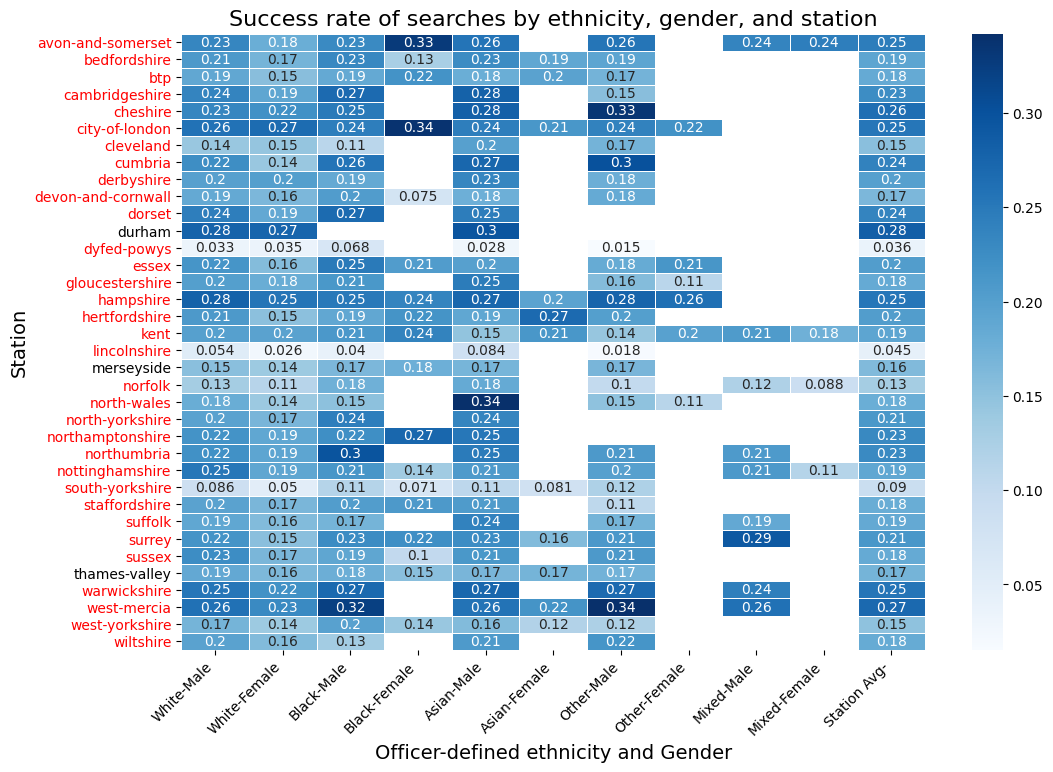

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt



# Select relevant columns
data = df_et[['station', 'Officer-defined ethnicity', 'success', 'Gender']].copy()

data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns=['Officer-defined ethnicity', 'Gender'], 
                              values='success', aggfunc='mean')



# Reorder columns to show 'White' ethnicity first, then 'Female' gender
pivot_data = pivot_data.reindex(columns=pd.MultiIndex.from_product([['White', 'Black', 'Asian', 'Other','Mixed'], ['Male', 'Female']]))

# Calculate average success rate for each station
pivot_data['Station Avg'] = pivot_data.mean(axis=1)
# Create copy of pivot table to highlight problematic stations
data_test = pivot_data.copy()

# Convert categorical column to string column
data_test.columns = data_test.columns.map(str)

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rate of searches by ethnicity, gender, and station', fontsize=16)
ax.set_xlabel('Officer-defined ethnicity and Gender', fontsize=14)
ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')

plt.show()


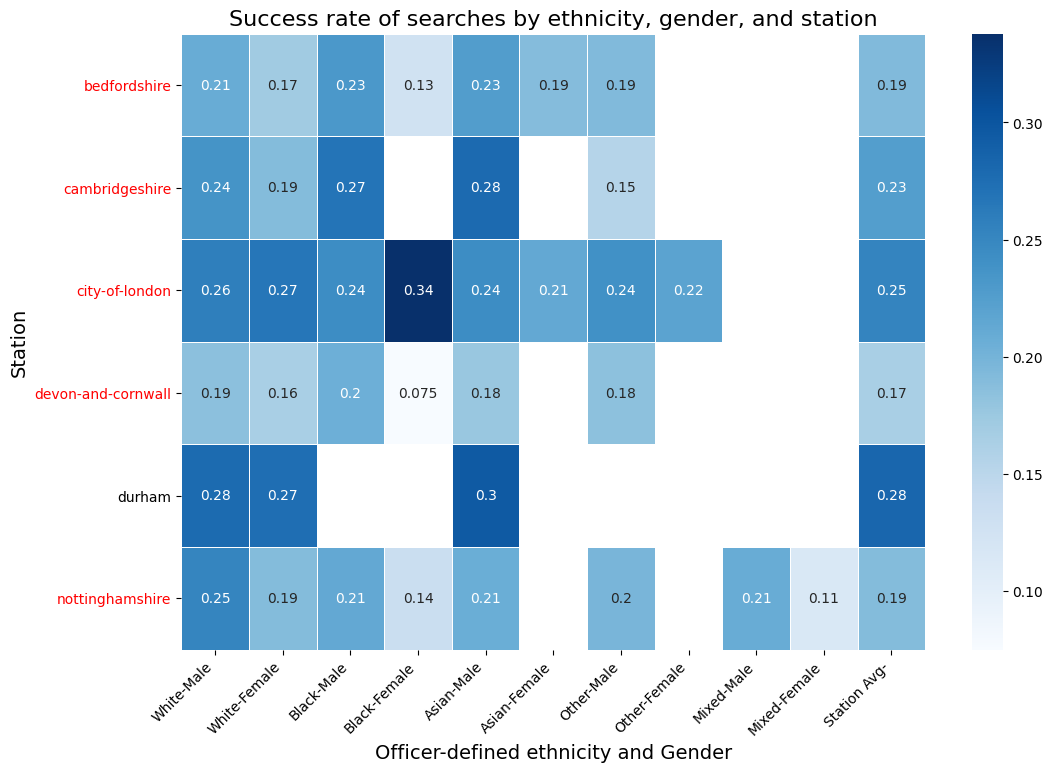

In [12]:
# Select relevant columns

stations= ['city-of-london', 'nottinghamshire', 'durham', 'cambridgeshire',
       'devon-and-cornwall', 'bedfordshire']
data = df_et[['station', 'Officer-defined ethnicity', 'success', 'Gender']].copy()

data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

data['station']= data[data['station'].isin(stations)]
# Pivot data
pivot_data = data.pivot_table(index='station', columns=['Officer-defined ethnicity', 'Gender'], 
                              values='success', aggfunc='mean')



# Reorder columns to show 'White' ethnicity first, then 'Female' gender
pivot_data = pivot_data.reindex(columns=pd.MultiIndex.from_product([['White', 'Black', 'Asian', 'Other','Mixed'], ['Male', 'Female']]))

# Calculate average success rate for each station
pivot_data['Station Avg'] = pivot_data.mean(axis=1)
# Create copy of pivot table to highlight problematic stations
data_test = pivot_data.copy()

# Convert categorical column to string column
data_test.columns = data_test.columns.map(str)

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rate of searches by ethnicity, gender, and station', fontsize=16)
ax.set_xlabel('Officer-defined ethnicity and Gender', fontsize=14)
ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')

plt.show()


In [13]:
data_test

,"('White', 'Male')","('White', 'Female')","('Black', 'Male')","('Black', 'Female')","('Asian', 'Male')","('Asian', 'Female')","('Other', 'Male')","('Other', 'Female')","('Mixed', 'Male')","('Mixed', 'Female')","('Station Avg', '')",problematic
station,,,,,,,,,,,,
bedfordshire,0.208745,0.170576,0.231590,0.127273,0.226019,0.189655,0.192308,NaN,NaN,NaN,0.192309,True
cambridgeshire,0.236866,0.190323,0.268212,NaN,0.278450,NaN,0.154762,NaN,NaN,NaN,0.225723,True
city-of-london,0.258346,0.266667,0.244221,0.337838,0.244318,0.212766,0.239865,0.219512,NaN,NaN,0.252942,True
devon-and-cornwall,0.185545,0.164776,0.204938,0.075000,0.176923,NaN,0.184211,NaN,NaN,NaN,0.165232,True
durham,0.278206,0.274648,NaN,NaN,0.295455,NaN,NaN,NaN,NaN,NaN,0.282769,False
nottinghamshire,0.252568,0.190647,0.213333,0.135135,0.206851,NaN,0.197917,NaN,0.209246,0.114286,0.189998,True


In [14]:
# Define a function to count the number of values below the column average, handling NaN values correctly
def count_below_avg(column):
    non_nan_vals = column[~np.isnan(column)]
    if len(non_nan_vals) == 0:
        return 0, 0
    else:
        below_avg = np.sum(non_nan_vals < np.nanmean(non_nan_vals))
        return below_avg, len(non_nan_vals)

# Create a list of column names to iterate through
cols_to_check = [col for col in pivot_data.columns if col[0] != 'Station Avg']


lib = {}
# Iterate through each column
for col in cols_to_check:
    # Initialize counters
    below_avg_count = 0
    total_count = 0
    # Iterate through each row in the column
    for row in pivot_data.index:
        # Check if the value is below the column average
        if not np.isnan(pivot_data[col][row]):
            if pivot_data[col][row] < (pivot_data[('Station Avg', '')][row]-0.05):
                below_avg_count += 1
            total_count += 1
    # Print the results
    name= f"{col[0]} {col[1]}"
    #print(name)
    lib[name]=[(below_avg_count/total_count)]
    


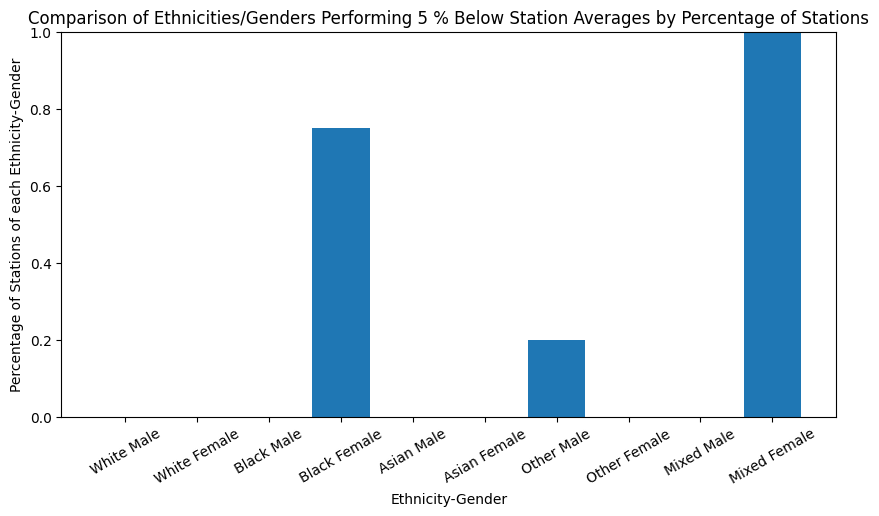

In [34]:
# Define the values to plot
values = lib

# Create a list of labels and values to plot
labels = list(values.keys())
y_values = [value[0] for value in values.values()]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, y_values)

# Plot a horizontal line for the average success rate
#ax.axhline(average_rate, color='red', linestyle='--', label='Average Success Rate')


# Set axis labels and title
ax.set_xlabel('Ethnicity-Gender')
ax.set_ylabel('Percentage of Stations of each Ethnicity-Gender')
ax.set_title('Comparison of Ethnicities/Genders Performing 5 % Below Station Averages by Percentage of Stations')
plt.xticks(rotation=30)
# Set the y-axis limits to 0-100
ax.set_ylim(0, 1)

# Display the plot
plt.show()

In [16]:
def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    return max_val - min_val > 0.05

# Convert categorical column to string column
data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot the data
pivot_data = data.pivot_table(index='station', columns='Officer-defined ethnicity', 
                              values='success', aggfunc='mean')

# Create new column with True/False values
pivot_data['problematic'] = pivot_data.apply(is_problematic, axis=1)

problematic_stations = pivot_data[pivot_data['problematic']].index.tolist()
print(problematic_stations)
#pivot_data



['cambridgeshire']


check if officer and self is very different data

## removal of clothing 

In [17]:
df_et.dtypes

observation_id                               object
Type                                         object
Date                                         object
Part of a policing operation                 object
Latitude                                    float64
Longitude                                   float64
Gender                                       object
Age range                                    object
Self-defined ethnicity                       object
Officer-defined ethnicity                    object
Legislation                                  object
Object of search                             object
Outcome                                      object
Outcome linked to object of search             bool
Removal of more than just outer clothing       bool
station                                      object
success                                       int64
dtype: object

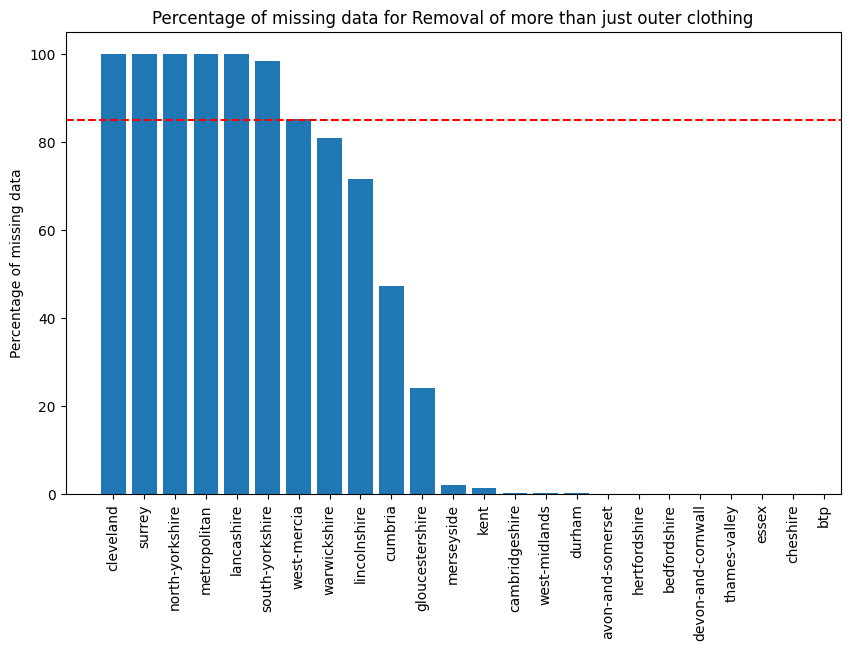

In [18]:
# Calculate the percentage of missing data for each station
missing_perc = df[df['Removal of more than just outer clothing'].isna()].groupby('station').size() / df.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Removal of more than just outer clothing')

# Add a horizontal line at 95%
plt.axhline(y=85, color='r', linestyle='--')

plt.show()

In [19]:
# Find stations where the "Outcome linked to object of search" is completely missing
df_new = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)

df_new.loc[ df_new['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False

stations_to_drop = df_new[df_new.groupby('station')['Removal of more than just outer clothing'].transform('count')==0]['station'].unique()

# Drop the stations from the dataframe
df_rc1 = df_new[~df_new['station'].isin(stations_to_drop)]
print("The stations droped were:",stations_to_drop)
print('humberside', 'lancashire','metropolitan','west-midlands',"leicestershire")

The stations droped were: ['surrey' 'north-yorkshire' 'cleveland']
humberside lancashire metropolitan west-midlands leicestershire


In [20]:
def clean_RC (df):
    
    df_ = df.copy()
    
    #df_= df_[['Officer-defined ethnicity',"Gender","Age range","station","Removal of more than just outer clothing","Outcome"]]
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']
    
    #df_= df_[df_['Gender']=="Female"]
    
    # Remove rows where age range is 'under 10'
    
    df_ = df_[df_['Age range'] != 'under 10']

    # Remove rows where gender is 'Other'
    df_ = df_[df_['Gender'] != 'Other']
    

    # Drop the stations from the dataframe
    df_ = df_[~df_['station'].isin(stations_to_drop)]


    df_['Outcome linked to object of search'] = df_['Outcome linked to object of search'].fillna(False)
    df_['Removal of more than just outer clothing'] = df_['Removal of more than just outer clothing'].fillna(False)
    df_['success'] = df_.apply(lambda x: 1 if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else 0, axis=1)
    
    
    
    return df_

df_rc = clean_RC(df_rc1)


In [21]:
# Subset the data for searches where outer clothing was removed
df_outer = df_rc[df_rc['Removal of more than just outer clothing'] == True]

# Compute the success rates separately for females and males
success_rate_female = df_outer[df_outer['Gender'] == 'Female']['success'].mean()
success_rate_male = df_outer[df_outer['Gender'] == 'Male']['success'].mean()

print(f"Success rate when outer clothing was removed for female suspects: {success_rate_female:.2%}")
print(f"Success rate when outer clothing was removed for male suspects: {success_rate_male:.2%}")


Success rate when outer clothing was removed for female suspects: 21.69%
Success rate when outer clothing was removed for male suspects: 31.46%


In [22]:
# Compute the success rate for each officer-defined ethnicity
ethnicities = df_outer['Officer-defined ethnicity'].unique()
for ethnicity in ethnicities:
    success_rate = df_outer[df_outer['Officer-defined ethnicity'] == ethnicity]['success'].mean()
    print(f"Success rate when outer clothing was removed for {ethnicity}: {success_rate:.2%}")


Success rate when outer clothing was removed for White: 30.38%
Success rate when outer clothing was removed for Black: 31.03%
Success rate when outer clothing was removed for Other: 35.35%
Success rate when outer clothing was removed for Asian: 27.26%
Success rate when outer clothing was removed for Mixed: 31.48%


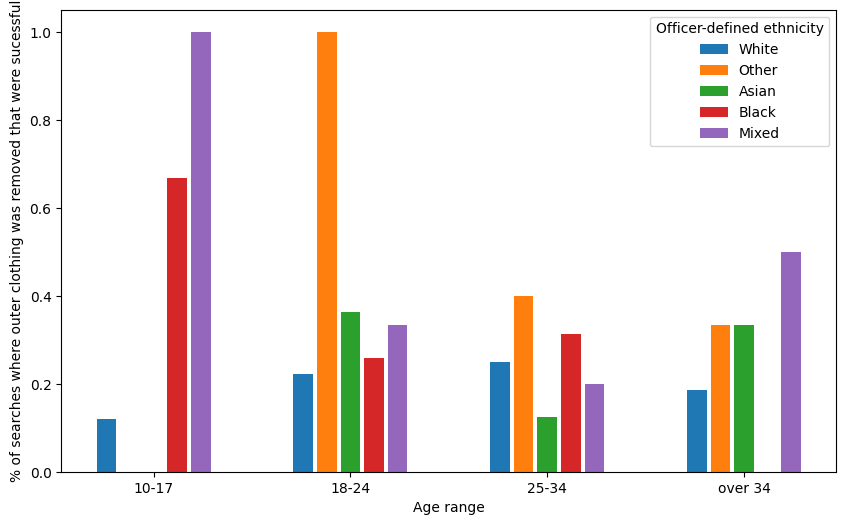

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# filter the data for females only
df_females = df_rc[(df_rc['Gender'] == 'Female') & (df_rc['Removal of more than just outer clothing'] == True) ]

# define the age ranges and officer-defined ethnicity values
age_ranges = ['10-17', '18-24', '25-34', 'over 34']
ethnicities = ['White', 'Other', 'Asian', 'Black', 'Mixed']

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width and gap between the bars
width = 0.1
gap = 0.02

# loop through each ethnicity and plot the bars for each age range
for i, ethnicity in enumerate(ethnicities):
    # get the subset of data for the current ethnicity
    ethnicity_data = df_females[df_females['Officer-defined ethnicity'] == ethnicity]
    # create a list to store the success rates for each age range
    success_rates = []
    for age_range in age_ranges:
        # get the subset of data for the current age range
        age_data = ethnicity_data[ethnicity_data['Age range'] == age_range]
        # filter the data for successful searches where "Removal of more than just outer clothing" is True
        success_data = age_data[(age_data['success'] == 1)]
        # calculate the success rate for the current age range and ethnicity
        success_rate = success_data.shape[0] / age_data.shape[0] if age_data.shape[0] > 0 else 0
        success_rates.append(success_rate)
    # plot the bars for the current ethnicity and age range
    x_pos = np.arange(len(age_ranges)) + i * (width + gap)
    ax.bar(x_pos, success_rates, width=width, label=ethnicity)

# add the x and y axis labels and the legend
ax.set_xlabel('Age range')
ax.set_ylabel('% of searches where outer clothing was removed that were sucessful')
ax.set_xticks(np.arange(len(age_ranges)) + ((len(ethnicities) - 1) / 2) * (width + gap))
ax.set_xticklabels(age_ranges)
ax.legend(title='Officer-defined ethnicity', loc='upper right')

# show the plot
plt.show()



In [24]:
df_rc.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station', 'success'],
      dtype='object')

In [25]:
df_rc_rate = df_rc[(df_rc['Gender'] == 'Female')  &(df_rc['Removal of more than just outer clothing'] == True) ]

threshold = 30

# Create a new dataframe that only includes data that meets the threshold criteria
#df_rc_rate = df_rc_rate.groupby(['Gender', 'Officer-defined ethnicity', 'Age range']).filter(lambda x: len(x) >= threshold)

df_rc_rate.groupby(['Gender','Age range','Officer-defined ethnicity'])["success"].count()

Gender  Age range  Officer-defined ethnicity
Female  10-17      Black                          3
                   Mixed                          1
                   White                         42
        18-24      Asian                         11
                   Black                         31
                   Mixed                          6
                   Other                          1
                   White                        265
        25-34      Asian                          8
                   Black                         16
                   Mixed                          5
                   Other                          5
                   White                        428
        over 34    Asian                          3
                   Black                          9
                   Mixed                          2
                   Other                          3
                   White                        590
Name: success, dtyp

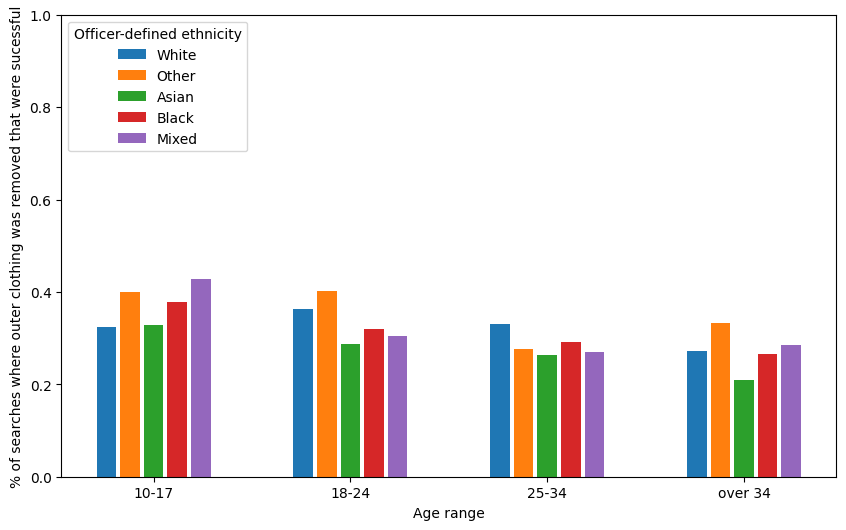

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# filter the data for females only
df_females = df_rc[(df_rc['Gender'] == 'Male') & (df_rc['Removal of more than just outer clothing'] == True) ]

# define the age ranges and officer-defined ethnicity values
age_ranges = ['10-17', '18-24', '25-34', 'over 34']
ethnicities = ['White', 'Other', 'Asian', 'Black', 'Mixed']

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width and gap between the bars
width = 0.1
gap = 0.02

# loop through each ethnicity and plot the bars for each age range
for i, ethnicity in enumerate(ethnicities):
    # get the subset of data for the current ethnicity
    ethnicity_data = df_females[df_females['Officer-defined ethnicity'] == ethnicity]
    # create a list to store the success rates for each age range
    success_rates = []
    for age_range in age_ranges:
        # get the subset of data for the current age range
        age_data = ethnicity_data[ethnicity_data['Age range'] == age_range]
        # filter the data for successful searches where "Removal of more than just outer clothing" is True
        success_data = age_data[(age_data['success'] == 1)]
        # calculate the success rate for the current age range and ethnicity
        success_rate = success_data.shape[0] / age_data.shape[0] if age_data.shape[0] > 0 else 0
        success_rates.append(success_rate)
    # plot the bars for the current ethnicity and age range
    x_pos = np.arange(len(age_ranges)) + i * (width + gap)
    ax.bar(x_pos, success_rates, width=width, label=ethnicity)

# add the x and y axis labels and the legend
ax.set_xlabel('Age range')
ax.set_ylabel('% of searches where outer clothing was removed that were sucessful')
ax.set_xticks(np.arange(len(age_ranges)) + ((len(ethnicities) - 1) / 2) * (width + gap))
ax.set_xticklabels(age_ranges)
ax.legend(title='Officer-defined ethnicity', loc='upper left')
ax.set_ylim(0, 1)
# show the plot
plt.show()


In [27]:
#ver cada area taxa de crime em diferentes areas 
# comprar sucess rates com numero actuall de positive outcomes
#mais chances de uma etnia ter interveçao policial sem razao para a procura 

/tmp/ipykernel_158/2927947203.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Officer-defined ethnicity'] = pd.Categorical(df_filtered['Officer-defined ethnicity'],


[]


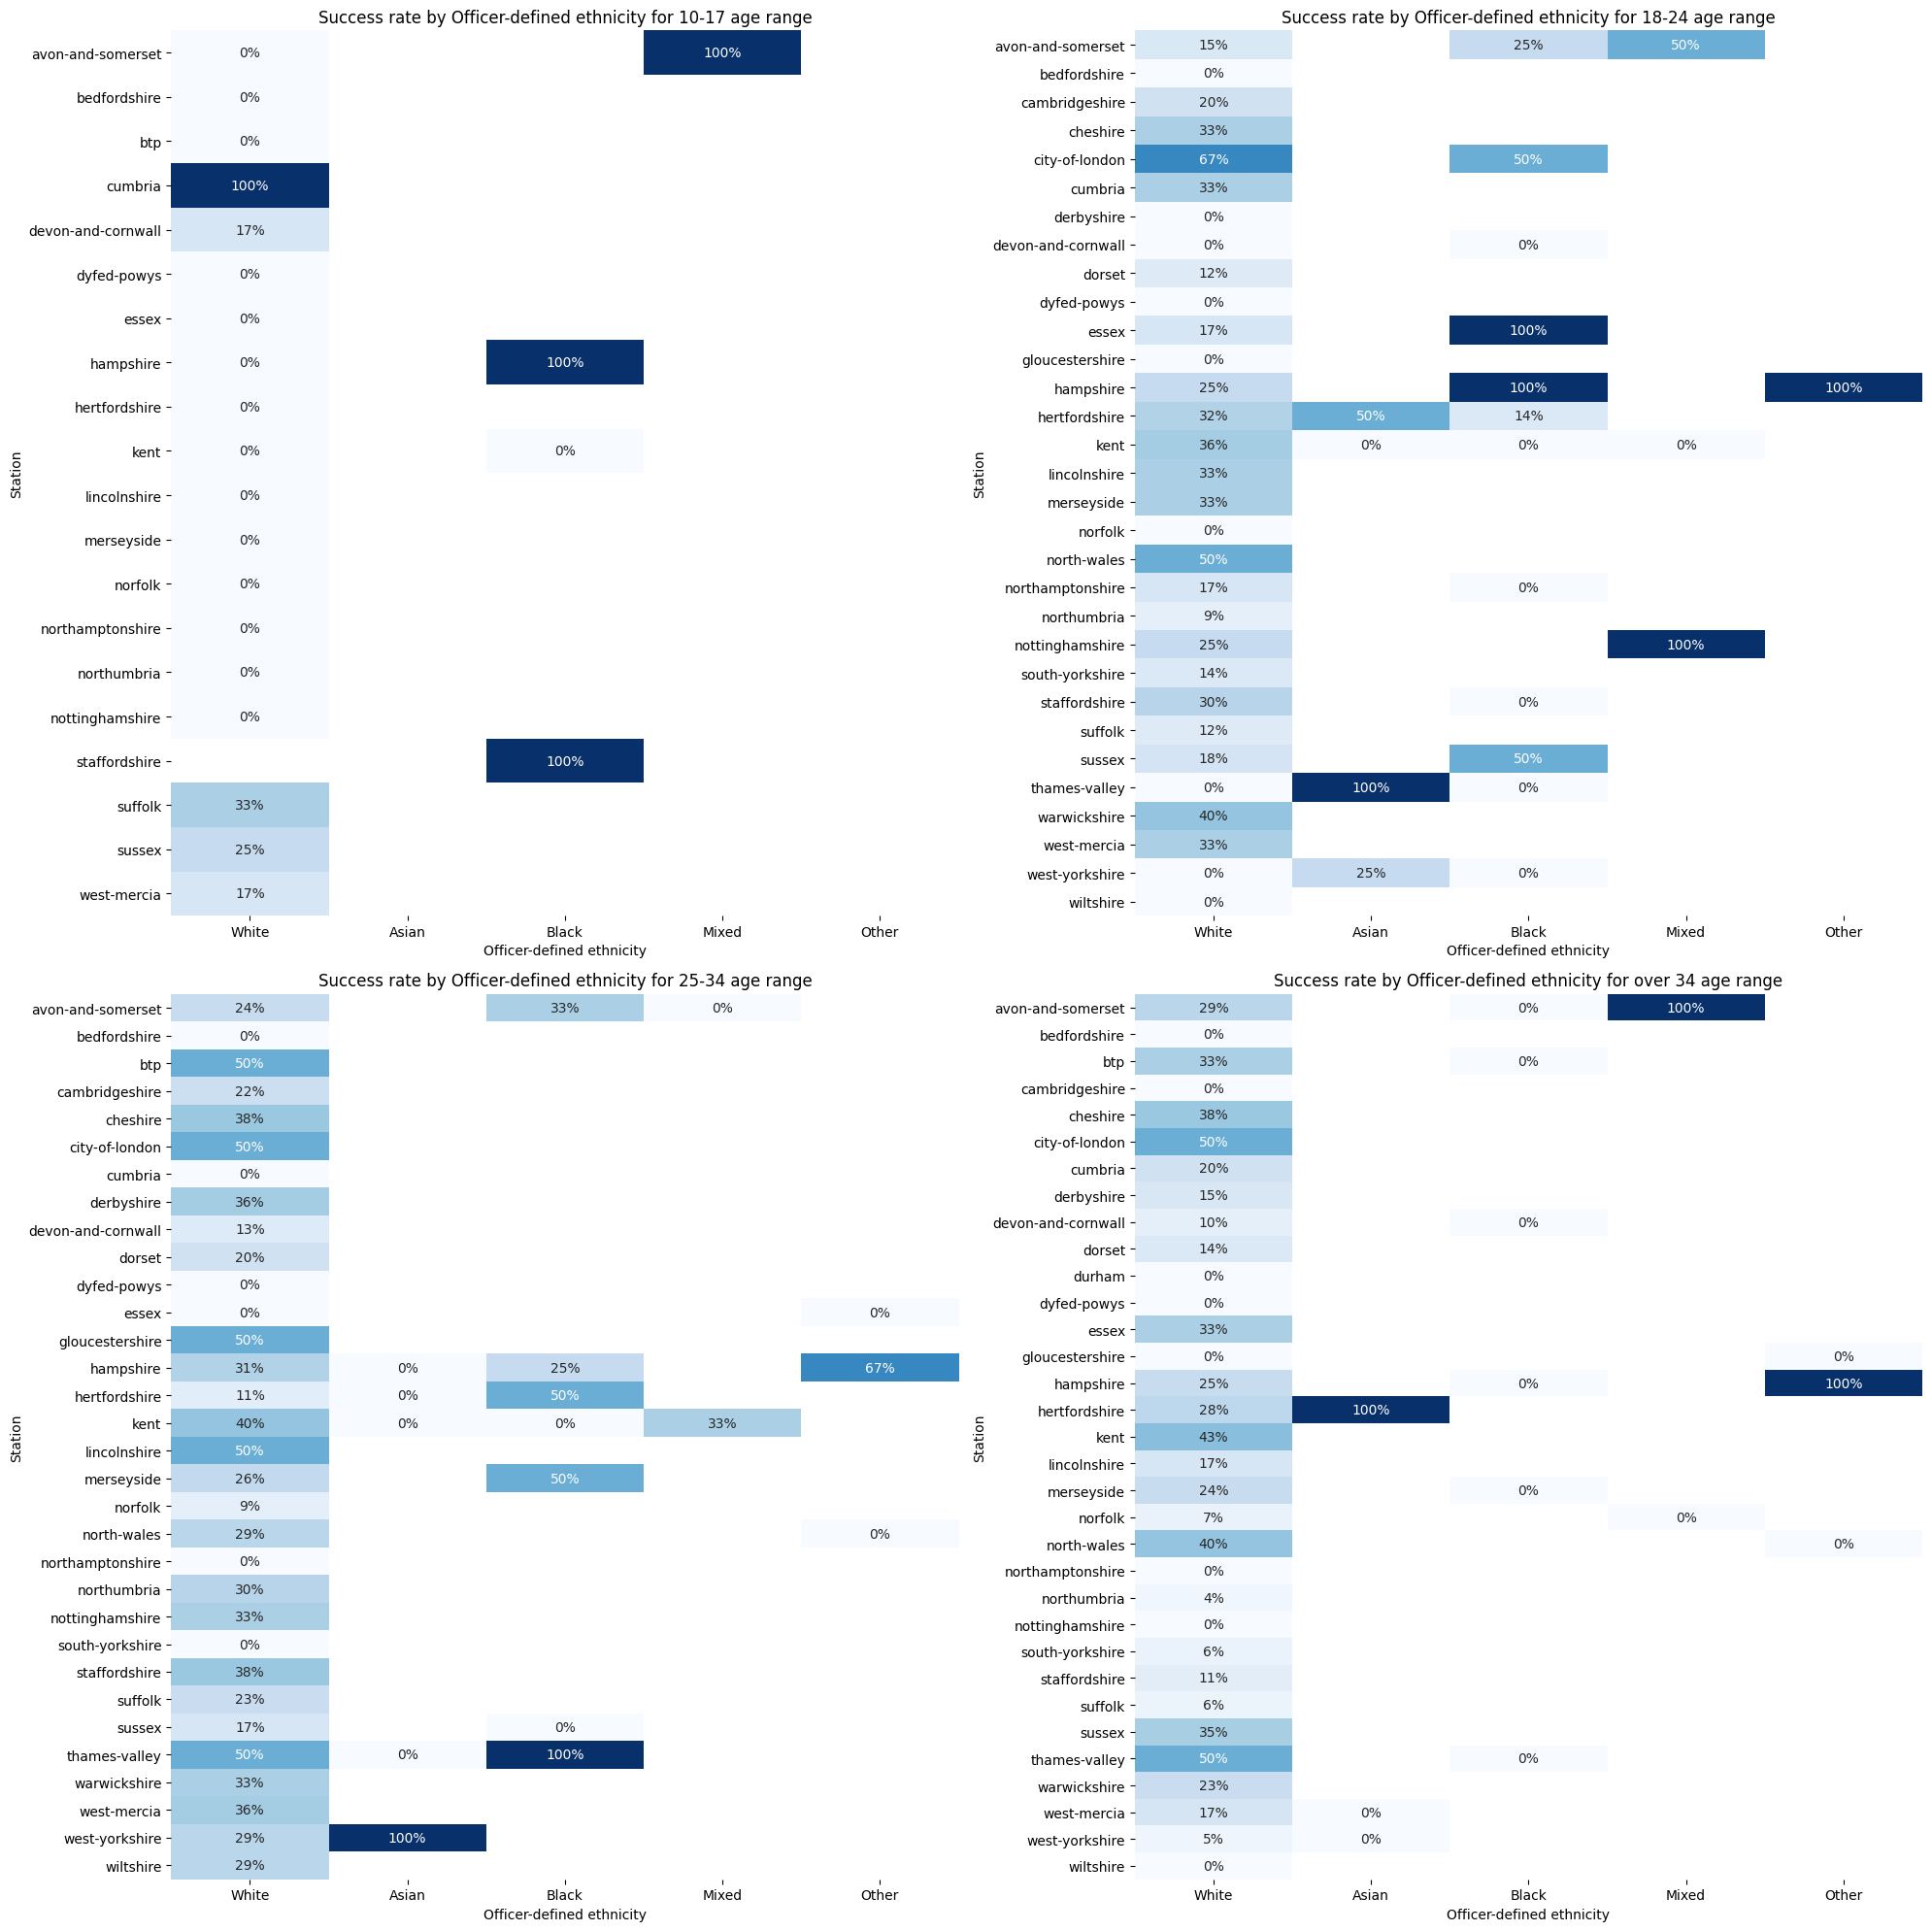

In [28]:
df_filtered = df_rc[(df_rc['Gender'] == 'Female') & (df_rc['Removal of more than just outer clothing'] == True) ]

# List of age ranges
age_ranges = ['10-17', '18-24', '25-34', 'over 34']

# Order the Officer-defined ethnicity by 'White' first
ethnicity_order = ['White', 'Asian', 'Black', 'Mixed', 'Other']
df_filtered['Officer-defined ethnicity'] = pd.Categorical(df_filtered['Officer-defined ethnicity'], 
                                                          categories=ethnicity_order[::], 
                                                          ordered=True)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))


problematic_stations = []
for i, ax in enumerate(axes.flatten()):
    # Filter by age range
    df_age = df_filtered[df_filtered['Age range'] == age_ranges[i]]

    # Calculate percentage success for each combination of station and ethnicity
    df_pivot = df_age.groupby(['station', 'Officer-defined ethnicity']).agg({'success': 'mean'}).reset_index().pivot(index='station', columns='Officer-defined ethnicity', values='success')

    #print(df_pivot)
    '''df_bla =df_pivot.copy()
    # Create new column with True/False values
    df_bla['problematic'] = df_bla.apply(is_problematic, axis=1)
    print("here")
    p_s = df_bla[df_bla['problematic']].index.tolist()
    for s in p_s:
        if s not in problematic_stations:
            problematic_stations.append(s)
    '''
    
    
    # Plot heatmap
    sns.heatmap(df_pivot, cmap='Blues', annot=True, fmt='.0%', cbar=False, ax=ax)
    ax.set_title(f"Success rate by Officer-defined ethnicity for {age_ranges[i]} age range")
    ax.set_xlabel("Officer-defined ethnicity")
    ax.set_ylabel("Station")
print(problematic_stations)
plt.tight_layout()
plt.show()

Based on the data you provided, there are a few stations that stand out in terms of having particularly high disparities in the success rates of searches among different ethnicities. These include:

Dorset: This station has a success rate of only 5% for searches on individuals of "Other" ethnicity, compared to success rates of around 23-27% for searches on individuals of other ethnicities. Durham: This station has a success rate of 43% for searches on individuals of "Other" ethnicity, which is much higher than the success rates of around 22-28% for searches on individuals of other ethnicities. Kent: This station has a success rate of only 15% for searches on individuals of "Other" ethnicity, compared to success rates of around 19-21% for searches on individuals of other ethnicities. Northumbria: This station has a success rate of around 20% for searches on individuals of Mixed ethnicity, compared to success rates of around 25-30% for searches on individuals of other ethnicities. Surrey: This station has a success rate of around 23% for searches on individuals of Mixed ethnicity, compared to success rates of around 22-31% for searches on individuals of other ethnicities. West Mercia: This station has a success rate of around 26-32% for searches on individuals of Mixed ethnicity, compared to success rates of around 26% for searches on individuals of other ethnicities. It's important to note that the presence of disparities in the success rates of searches does not necessarily indicate intentional discrimination on the part of the police. There may be a range of factors that contribute to these disparities, including unconscious biases, differences in the circumstances of searches, and differences in the underlying patterns of criminal activity in different ethnic groups. However, identifying these disparities is an important first step in addressing any potential issues of discrimination and promoting more equitable policing practices.

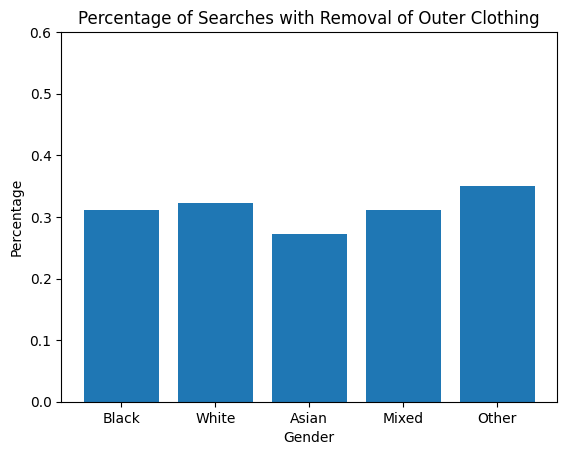

In [29]:
data = df_et.copy()
import matplotlib.pyplot as plt

# Create a subset of data where 'Removal of more than just outer clothing' is True
subset = df_females[df_females['success'] == 1]

# Group the subset by gender and count the number of searches
grouped = subset.groupby('Officer-defined ethnicity')['Officer-defined ethnicity'].count()

# Calculate the percentage of searches where outer clothing was removed separately for men and women
women_removed = grouped.loc['Black'] / df_females['Officer-defined ethnicity'].value_counts()['Black']
men_removed = grouped.loc['White'] / df_females['Officer-defined ethnicity'].value_counts()['White']
men_removed1 = grouped.loc['Asian'] / df_females['Officer-defined ethnicity'].value_counts()['Asian']
men_removed2 = grouped.loc['Mixed'] / df_females['Officer-defined ethnicity'].value_counts()['Mixed']
men_removed3 = grouped.loc['Other'] / df_females['Officer-defined ethnicity'].value_counts()['Other']

# Plot the results
plt.bar(['Black', 'White',"Asian",'Mixed',"Other"], [women_removed, men_removed,men_removed1,men_removed2,men_removed3])
plt.title('Percentage of Searches with Removal of Outer Clothing')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.ylim(0, 0.6)
plt.show()


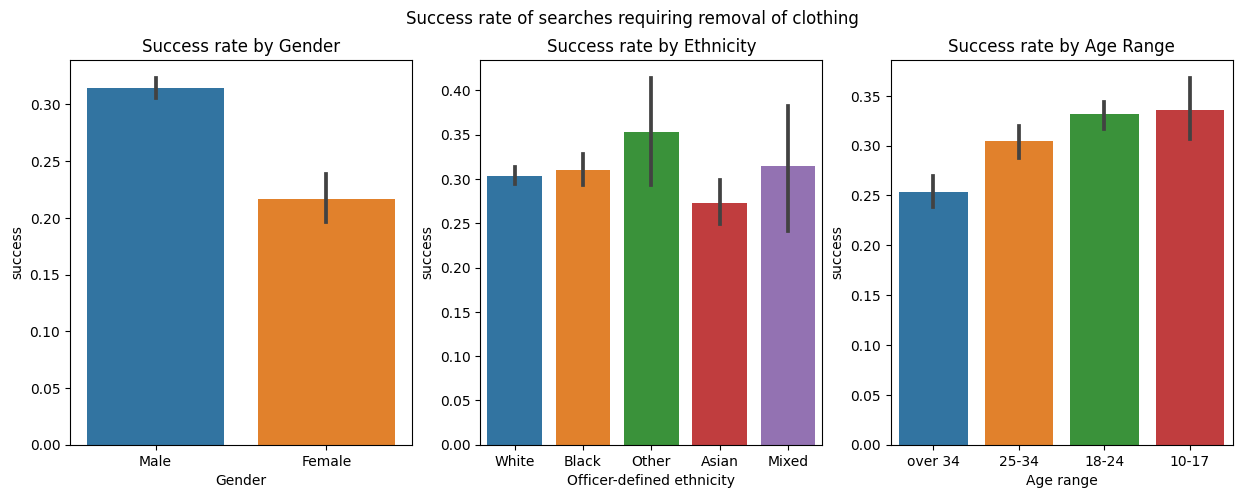

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
data = df_rc[['Gender', "Officer-defined ethnicity", 'Age range', 'Removal of more than just outer clothing', 'success']]

# Filter the data to only include searches where removal of clothing was necessary
data = data[data['Removal of more than just outer clothing'] == True]

# Create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Plot 1: success rate by gender
sns.barplot(x='Gender', y='success', data=data, ax=axs[0])
axs[0].set_title('Success rate by Gender')

# Plot 2: success rate by ethnicity
sns.barplot(x='Officer-defined ethnicity', y='success', data=data, ax=axs[1])
axs[1].set_title('Success rate by Ethnicity')

# Plot 3: success rate by age range
sns.barplot(x='Age range', y='success', data=data, ax=axs[2])
axs[2].set_title('Success rate by Age Range')

# Set the overall title of the figure
fig.suptitle('Success rate of searches requiring removal of clothing')

plt.show()


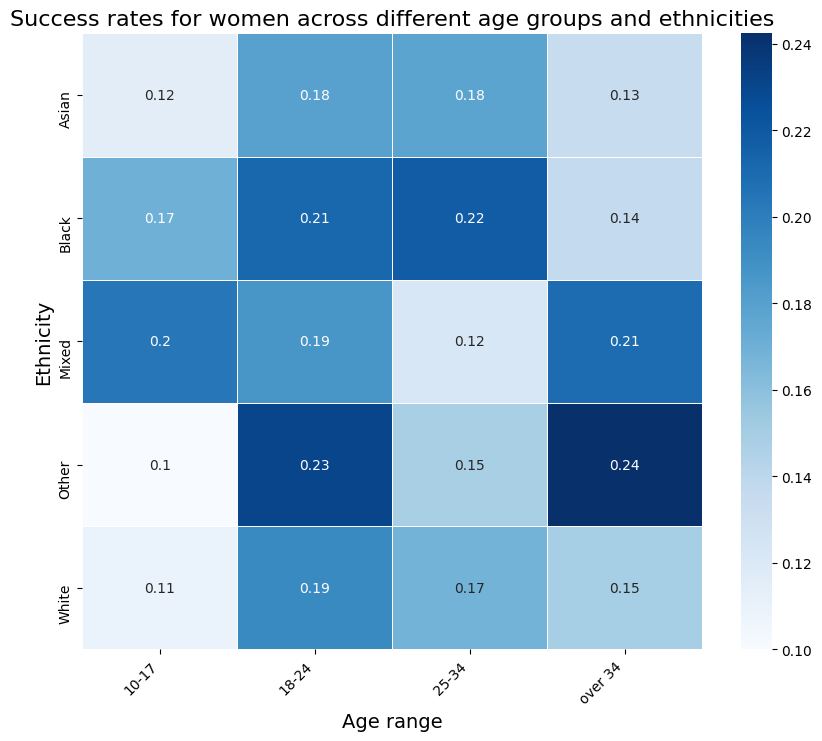

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for women only
df_women = df_et[df_et['Gender'] == 'Female']

# Create a pivot table to get the search rates for each ethnicity and age range
pivot_data = df_women.pivot_table(index='Officer-defined ethnicity', columns='Age range', 
                                  values='success', aggfunc='mean')

# Create heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot_data, cmap='Blues', annot=True, linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rates for women across different age groups and ethnicities', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)
ax.set_ylabel('Ethnicity', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


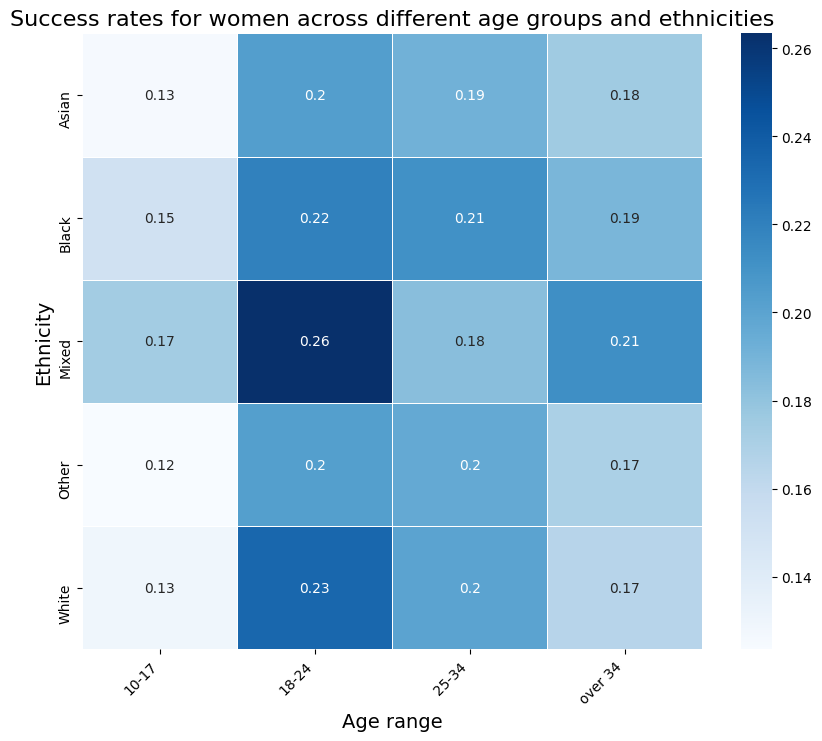

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for women only
df_women = df_et[df_et['Gender'] == 'Male']

# Create a pivot table to get the search rates for each ethnicity and age range
pivot_data = df_women.pivot_table(index='Officer-defined ethnicity', columns='Age range', 
                                  values='success', aggfunc='mean')

# Create heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot_data, cmap='Blues', annot=True, linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rates for women across different age groups and ethnicities', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)
ax.set_ylabel('Ethnicity', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()